In [31]:
#
# A "sanity check" for the parameters and data
#
# This is the first part of "June30_CMB_Likelihoods_2015.ipynb"
#
%matplotlib inline
import math
import matplotlib.pyplot as plt 
import numpy as np
import healpy as hp
import pyfits as pf
import astropy as ap
import os
from scipy.special import eval_legendre  ##special scipy function

In [32]:
cd ~/Desktop/CMBintheLikeHoodz/Likelihood_Comparison

/Users/evanbiederstedt/Desktop/CMBintheLikeHoodz/Likelihood_Comparison


In [33]:
camb1 = "camb_nside16_lmax32_alms.fits"
camb2 = "camb_nside16_lmax32_map.fits"
camb3 = "camb_nside16_lmax32_scalcls.fits"
planck1 = "100GHz_nside16_lmax32_cls.fits"
planck2 = "100GHz_nside16_lmax32_cmb_alm.fits"
planck3 = "100GHz_nside16_lmax32_sky_alm.fits"
planck4 = "100GHz_nside16_lmax32_skymap.fits"

nside = 16

In [34]:
npix = 12*(nside**2) #total number of pixels, npix
LMAX = ((2*nside)) #maximum l of the power spectrum C_l
heal_npix = hp.nside2npix(nside) # Healpix calculated npix

print "The total number of pixels is " + str(npix)
print "The maximum ell of the power spectrum C_l set to lmax = 2*nside " +str(LMAX)
print "Healpix tells me total number of pixels npix is equal to " + str(heal_npix)

The total number of pixels is 3072
The maximum ell of the power spectrum C_l set to lmax = 2*nside 32
Healpix tells me total number of pixels npix is equal to 3072


In [35]:
#
# Begin with a Munich Planck-simulated map, and CAMB Boltzmann-code generated C_l values
#
# Theoretical scalar C_l array, CAMB
#
# open a FITS file, theoretical C_l values generated by CAMB
# type()=pyfits.hdu.hdulist.HDUList
cl_open = pf.open(camb3)
# recall camb3 = "camb_nside16_lmax32_scalcls.fits"

In [36]:
theoryCls_arr1 = cl_open[1].data
print theoryCls_arr1[:10]
# Recall there are four columns: temp, E pol, B pol, grad-temp cross terms
# first two values are zero, i.e. monopole, dipole
# XXX.field() references columns by 0-index
# field(0) is temperature values
# all Cl scalar temp values put into ndarray
# type()=numpy.ndarray

[(0.0, 0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0)
 (1.2639207e-09, 5.5308927e-14, 0.0, 3.6016001e-12)
 (5.8827504e-10, 4.5345086e-14, 0.0, 2.2704995e-12)
 (3.2867314e-10, 3.0680604e-14, 0.0, 1.4030458e-12)
 (2.065753e-10, 1.8198442e-14, 0.0, 8.6680196e-13)
 (1.4100289e-10, 9.6222612e-15, 0.0, 5.4035639e-13)
 (1.0233801e-10, 4.5884262e-15, 0.0, 3.3960166e-13)
 (7.7812937e-11, 2.0448748e-15, 0.0, 2.1437516e-13)
 (6.1362422e-11, 9.4503657e-16, 0.0, 1.3715881e-13)]


In [37]:
cltemps = theoryCls_arr1.field(0) 
print cltemps
print "The length of the array of theoretical Cl's is " +str(len(cltemps))
print "The array contains [C_0, C_1, C_2,..., C_" +str(len(cltemps)-1) + "]"
#print type(cltemps)=numpy.ndarray

[  0.00000000e+00   0.00000000e+00   1.26392075e-09   5.88275040e-10
   3.28673144e-10   2.06575299e-10   1.41002890e-10   1.02338013e-10
   7.78129366e-11   6.13624221e-11   4.98225766e-11   4.14123076e-11
   3.50811741e-11   3.01814025e-11   2.63133803e-11   2.32104266e-11
   2.06850804e-11   1.86004823e-11   1.68565179e-11   1.53792031e-11
   1.41130128e-11   1.30162998e-11   1.20591913e-11   1.12186076e-11
   1.04760627e-11   9.81660760e-12   9.22804801e-12   8.70035207e-12
   8.22520958e-12   7.79568684e-12   7.40596039e-12   7.05096528e-12
   6.72585642e-12]
The length of the array of theoretical Cl's is 33
The array contains [C_0, C_1, C_2,..., C_32]


In [38]:
# remove monopole l=0 and dipole l=1
theoryCl = cltemps[2:]
# len(theoryCl) = 31
print theoryCl
# theoryCl is np.ndarray of theoretical [C_2, C_3, C_4, ..., C_32]

[  1.26392075e-09   5.88275040e-10   3.28673144e-10   2.06575299e-10
   1.41002890e-10   1.02338013e-10   7.78129366e-11   6.13624221e-11
   4.98225766e-11   4.14123076e-11   3.50811741e-11   3.01814025e-11
   2.63133803e-11   2.32104266e-11   2.06850804e-11   1.86004823e-11
   1.68565179e-11   1.53792031e-11   1.41130128e-11   1.30162998e-11
   1.20591913e-11   1.12186076e-11   1.04760627e-11   9.81660760e-12
   9.22804801e-12   8.70035207e-12   8.22520958e-12   7.79568684e-12
   7.40596039e-12   7.05096528e-12   6.72585642e-12]


In [39]:
# Our input data is Gaerching generated, noiseless full-sky map
# Temperature map: here we use Planck simulated map from Munich, not CAMB map
# http://gavo.mpa-garching.mpg.de/planck/
#
# Read in with Healpy routine/function
#
# Use planck4 = "100GHz_nside16_lmax32_skymap.fits"
# This is a simulated data, 100GHz (where CMB dominates), no foregrounds
# 
mapread_planck4 = hp.read_map(planck4) # Healpix routine, input the sky map

NSIDE = 16
ORDERING = RING in fits file


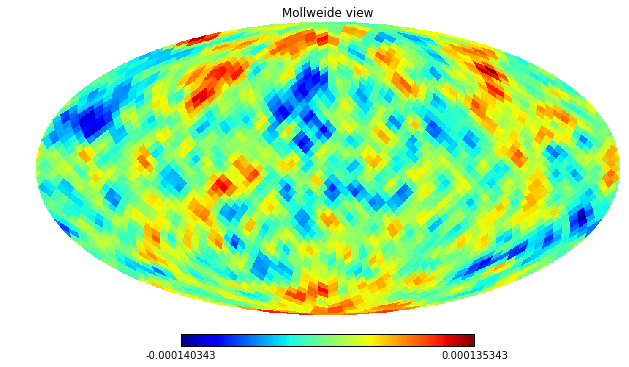

In [40]:
hp.mollview(mapread_planck4) # visualization of full-sky CMB map, nside=16, lmax=32

In [41]:
# The uploaded temperature map is mapread_planck4 = hp.read_map(planck4)
print type(mapread_planck4) # type(mapread_planck4) = np.ndarray
print mapread_planck4.shape # mapread_planck4.shape = (3072, ) = (N_pix, )
#
# rename array for convenience
tempval = mapread_planck4
print tempval

<type 'numpy.ndarray'>
(3072,)
[ -5.36934613e-06   8.56208499e-06  -2.42593651e-05 ...,   1.00589954e-04
   8.22511720e-05   6.55527765e-05]


In [42]:
# Next, we use healpy map2alm to tranform to alm values
# Our input data is CAMB generated, noiseless full-sky map
# We calculate an array of a_lm from this by using Healpix map2alm, a subroutine of anafast
#
# map2alm only outputs m >=0 values, because m = -l values are equivalent to m = +l values
#
# Using map2alm, the length of the alm array is expected to be:
# (mmax * (2 * lmax + 1 - mmax)) / 2 + lmax + 1)"
#
# For mmax = lmax, this is l(l+1)/2 + l + 1
# i.e. 
# l = 0, there is 1
# l = 1, there is 3
# l = 2, there is 6
# l = 3, there is 10
# l = 4, there is 15
# etc.
almarr = hp.map2alm(mapread_planck4)                # This is an array of a_lm values
print "The array of spherical harmonic coefficients a_lm is"
print almarr
print "The arr.shape is " + str(almarr.shape)
print "The length of a_lm array is " + str(len(almarr))
#
print "For l=3, map2alm gives (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33)"
print "However, this is NOT the order of the output! See below"
# In the Fortran F90 subroutines, complex alm are stored in an array that has 
# two dimensions to contain coefficients for positive and negative m values.
# Healpy doesn't do this....I think

print "============================="
print "============================="
print "Check indices with healpy.sphtfunc.Alm.getidx(lmax, l, m)"
print "Default ordering of healpy.map2alm() output is "
print "(0,0), (1,0), ..., (lmax, 0),"
print "(1,1), (2,1), ...., (lmax, 1),"
print "(2,2), .... (lmax, 2),(3,3), ...., (lmax, 3), etc. , .... (lmax, lmax)."


The array of spherical harmonic coefficients a_lm is
[ -2.31017678e-09 +0.00000000e+00j  -9.52615975e-10 +0.00000000e+00j
   2.65461833e-05 +0.00000000e+00j ...,   2.18198095e-14 +7.05484274e-14j
  -1.89836768e-12 -5.77749155e-13j  -2.40742355e-13 -1.30069701e-13j]
The arr.shape is (1176,)
The length of a_lm array is 1176
For l=3, map2alm gives (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33)
However, this is NOT the order of the output! See below
Check indices with healpy.sphtfunc.Alm.getidx(lmax, l, m)
Default ordering of healpy.map2alm() output is 
(0,0), (1,0), ..., (lmax, 0),
(1,1), (2,1), ...., (lmax, 1),
(2,2), .... (lmax, 2),(3,3), ...., (lmax, 3), etc. , .... (lmax, lmax).


In [43]:
# ==========================
# DEMONSTRATION
# Notice how a_lm is indexed
# ==========================

mmm = np.arange(12) # define a map, i.e. an array of 12 "pixels"
lmaxxx = 4
alm = hp.map2alm(mmm, lmax=lmaxxx) # spherical harmonic transform
lm = hp.map2alm(mmm, lmax=lmaxxx) # spherical harmonic transform
print(alm)
print(alm.shape)

# So alm is actually a 1D vector.
# How is alm indexed?


l, m = hp.Alm.getlm(lmax=lmaxxx)
print(l)

print(m)




print "The l values are "+str(l)
print "The m values are "+str(m)
print " (l,m) is in order " +str(list(zip(l,m)))
#
# l, m = hp.Alm.getlm(lmax=lmax)
# print(l)
# [0 1 2 1 2 2]
# print(m)
# [0 0 0 1 1 2]
#
#
# So, for l = 2, m is [0, 1, 2].
#
# ==========================
# Notice how a_lm is indexed
# ==========================
#
#
#

[  1.43186913e+01 +0.00000000e+00j  -9.06158785e+00 +0.00000000e+00j
  -7.57672587e+00 +0.00000000e+00j   5.38292381e+00 +0.00000000e+00j
   2.49127749e+00 +0.00000000e+00j   6.02204636e-01 -2.01587603e+00j
   4.55476051e-16 +1.48937220e-15j   2.43950547e-01 -3.28507898e-01j
  -2.47937026e-17 +3.49331635e-16j   3.65595455e-01 -7.92402132e+00j
   5.92284905e-17 -4.53852723e-15j  -3.16614952e-01 -1.44872968e+01j
  -2.28780515e-03 +4.33449165e-01j  -5.66350430e-16 +1.59192782e-15j
   1.08501635e+01 -3.35394518e-16j]
(15,)
[0 1 2 3 4 1 2 3 4 2 3 4 3 4 4]
[0 0 0 0 0 1 1 1 1 2 2 2 3 3 4]
The l values are [0 1 2 3 4 1 2 3 4 2 3 4 3 4 4]
The m values are [0 0 0 0 0 1 1 1 1 2 2 2 3 3 4]
 (l,m) is in order [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (1, 1), (2, 1), (3, 1), (4, 1), (2, 2), (3, 2), (4, 2), (3, 3), (4, 3), (4, 4)]


In [44]:
# Check with healpy.sphtfunc.Alm.getidx(lmax, l, m)
# Returns index corresponding to (l,m) in an array describing alm up to lmax.
#
ell, emm = hp.Alm.getlm(lmax=32)

print "len(ell) is " +str(len(ell))
print "len(emm) is "+str(len(emm))
print "l values are "+str(ell[:10])
print "m values are "+str(emm[:10])
pairs = list(zip(ell, emm)) # put values together in pairs, zip()
ellemm = np.vstack((ell,emm)).T  # equivalent to list(zip(ell,emm)), but uses numpy throughout
print "Indices for a_lm for lmax (l, m) are:" 
print str(pairs[:50]) # The expected output


len(ell) is 561
len(emm) is 561
l values are [0 1 2 3 4 5 6 7 8 9]
m values are [0 0 0 0 0 0 0 0 0 0]
Indices for a_lm for lmax (l, m) are:
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


In [45]:
print ellemm[:10]

[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]
 [6 0]
 [7 0]
 [8 0]
 [9 0]]


In [46]:
#
# For our first test, mode l = 3, we need to access a_lm coefficients a_30, a_31, a_32, a_33
# To find this for lmax = 32, we use
# healpy.sphtfunc.Alm.getidx(lmax, l, m)
# Returns index corresponding to (l,m) in an array describing alm up to lmax.
#
# Find the indices
index_a30 = hp.Alm.getidx(lmax=32, l=3, m=0)
index_a31 = hp.Alm.getidx(lmax=32, l=3, m=1)
index_a32 = hp.Alm.getidx(lmax=32, l=3, m=2)
index_a33 = hp.Alm.getidx(lmax=32, l=3, m=3)

In [47]:
print "Index a_30 is " +str(index_a30)
print "Index a_31 is "+str(index_a31)
print "Index a_32 is "+str(index_a32)
print "Index a_33 is "+str(index_a33)

Index a_30 is 3
Index a_31 is 35
Index a_32 is 66
Index a_33 is 96


In [48]:
#
# Create an array with only the values a_3m, i.e. a_30, a_31, a_32, a_33
#
# First convert the array of alm coefficients into a real
#
realalm = almarr.real
#
print realalm[:36]

[ -2.31017678e-09  -9.52615975e-10   2.65461833e-05   9.40623087e-07
   2.00021958e-05  -1.51649063e-05  -1.39254136e-06  -9.33866127e-06
   8.02083605e-06   3.08728239e-06  -9.65554187e-06  -5.97494409e-06
   3.57962700e-06  -2.84514045e-06   1.09318419e-06  -9.24471250e-06
   5.53151471e-06  -2.97313199e-06  -3.86777913e-07   4.40351200e-06
  -2.32386723e-06   1.40708109e-06  -1.04757477e-06  -7.14480702e-07
  -3.61133631e-06   3.45552001e-08   1.01058745e-06  -2.80470416e-06
  -4.19635640e-08  -1.93088194e-06   1.98468254e-06   1.12227258e-06
  -1.49841127e-06   1.77477994e-09  -1.20584331e-08   2.83992347e-09]


In [49]:
empty_almlist = []
#
a30 = realalm[3]
a31 = realalm[35]
a32 = realalm[66]
a33 = realalm[96]
#
print "a30 is " + str(a30)
print "a31 is " + str(a31)
print "a32 is " + str(a32)
print "a33 is " + str(a33)
#
print str(pairs[3]) # Check with our output above
print str(pairs[35])
print str(pairs[66])
print str(pairs[96])
#
empty_almlist.append(a30)
empty_almlist.append(a31)
empty_almlist.append(a32)
empty_almlist.append(a33)
#
print empty_almlist

a30 is 9.40623086569e-07
a31 is 2.8399234655e-09
a32 is 1.96302697687e-06
a33 is -8.71036819164e-06
(3, 0)
(3, 1)
(3, 2)
(3, 3)
[9.4062308656887499e-07, 2.8399234654951283e-09, 1.9630269768714357e-06, -8.7103681916393811e-06]


In [50]:
# create array of real-valued alm coefficients, a30 a31 a32 a33
realalm3 = np.asarray(empty_almlist) # np.asarray() converts input into an array
print realalm3

[  9.40623087e-07   2.83992347e-09   1.96302698e-06  -8.71036819e-06]


In [51]:
# Repeat the above procedure for mode l = 4, i.e. a40 a41 a42 a43 a44
# Find the indices
index_a40 = hp.Alm.getidx(lmax=32, l=4, m=0)
index_a41 = hp.Alm.getidx(lmax=32, l=4, m=1)
index_a42 = hp.Alm.getidx(lmax=32, l=4, m=2)
index_a43 = hp.Alm.getidx(lmax=32, l=4, m=3)
index_a44 = hp.Alm.getidx(lmax=32, l=4, m=4)
#
print "Index a_40 is " +str(index_a40)
print "Index a_41 is "+str(index_a41)
print "Index a_42 is "+str(index_a42)
print "Index a_43 is "+str(index_a43)
print "Index a_44 is "+str(index_a44)
#
# Check with the above ouput
print str(pairs[4]) 
print str(pairs[36])
print str(pairs[67])
print str(pairs[97])
print str(pairs[126])
#
emptylistalm2 = []
#
print realalm
#
a40 = realalm[4]
a41 = realalm[36]
a42 = realalm[67]
a43 = realalm[97]
a44 = realalm[127]
#
print "a40 is " + str(a40)
print "a41 is " + str(a41)
print "a42 is " + str(a42)
print "a43 is " + str(a43)
print "a44 is " + str(a44)
#
emptylistalm2.append(a40)
emptylistalm2.append(a41)
emptylistalm2.append(a42)
emptylistalm2.append(a43)
emptylistalm2.append(a44)
#
print emptylistalm2

Index a_40 is 4
Index a_41 is 36
Index a_42 is 67
Index a_43 is 97
Index a_44 is 126
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
[ -2.31017678e-09  -9.52615975e-10   2.65461833e-05 ...,   2.18198095e-14
  -1.89836768e-12  -2.40742355e-13]
a40 is 2.00021957893e-05
a41 is -1.18223178483e-08
a42 is 1.86717689383e-06
a43 is -1.14394087052e-05
a44 is -1.78033877877e-09
[2.000219578927562e-05, -1.1822317848304192e-08, 1.8671768938335287e-06, -1.1439408705247353e-05, -1.7803387787705309e-09]


In [52]:
# create array of real-valued alm coefficients, a40 a41 a42 a43 a44
realalm4 = np.asarray(emptylistalm2) # np.asarray() converts input into an array
print realalm4

[  2.00021958e-05  -1.18223178e-08   1.86717689e-06  -1.14394087e-05
  -1.78033878e-09]


In [53]:
# Calculate (abs(alm))**2 i.e. |alm|^2
abs_alm3 = np.absolute(realalm3)
abs_alm4 = np.absolute(realalm4)
print abs_alm3
print abs_alm4
# Now calculate the squares element-wise, x**2
alm3_squared = abs_alm3**2
alm4_squared = abs_alm4**2
print alm3_squared
print alm4_squared

[  9.40623087e-07   2.83992347e-09   1.96302698e-06   8.71036819e-06]
[  2.00021958e-05   1.18223178e-08   1.86717689e-06   1.14394087e-05
   1.78033878e-09]
[  8.84771791e-13   8.06516529e-18   3.85347491e-12   7.58705140e-11]
[  4.00087836e-10   1.39767199e-16   3.48634955e-12   1.30860072e-10
   3.16960617e-18]


In [54]:
# For l = 3 test, we need theoretical value of C_3; ditto for l = 4
print theoryCl
C3 = theoryCl[1]
print "C_3 is " +str(C3)
C4 = theoryCl[2]
print "C_4 is "+str(C4)

[  1.26392075e-09   5.88275040e-10   3.28673144e-10   2.06575299e-10
   1.41002890e-10   1.02338013e-10   7.78129366e-11   6.13624221e-11
   4.98225766e-11   4.14123076e-11   3.50811741e-11   3.01814025e-11
   2.63133803e-11   2.32104266e-11   2.06850804e-11   1.86004823e-11
   1.68565179e-11   1.53792031e-11   1.41130128e-11   1.30162998e-11
   1.20591913e-11   1.12186076e-11   1.04760627e-11   9.81660760e-12
   9.22804801e-12   8.70035207e-12   8.22520958e-12   7.79568684e-12
   7.40596039e-12   7.05096528e-12   6.72585642e-12]
C_3 is 5.88275e-10
C_4 is 3.28673e-10


In [55]:
# For lmax = 32, we must create an array of ell values, i.e. [0 1 2 3....31 32]
ell = np.arange(33)
print ell
# 
# Subtract the monopole and dipole, l=0, l=1
ellval = ell[2:]
print ellval 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]


In [56]:
# Calculate an array of (2*l + 1)C_l 
# i.e. 5*C_2, 7*C_3, 9*C_4, 11*C_5, 13*C_6, ...
print theoryCl

for i in ellval:
    paramsCl = (2*ellval + 1)*theoryCl # define array (2*l + 1)C_l 
    
print paramsCl

[  1.26392075e-09   5.88275040e-10   3.28673144e-10   2.06575299e-10
   1.41002890e-10   1.02338013e-10   7.78129366e-11   6.13624221e-11
   4.98225766e-11   4.14123076e-11   3.50811741e-11   3.01814025e-11
   2.63133803e-11   2.32104266e-11   2.06850804e-11   1.86004823e-11
   1.68565179e-11   1.53792031e-11   1.41130128e-11   1.30162998e-11
   1.20591913e-11   1.12186076e-11   1.04760627e-11   9.81660760e-12
   9.22804801e-12   8.70035207e-12   8.22520958e-12   7.79568684e-12
   7.40596039e-12   7.05096528e-12   6.72585642e-12]
[  6.31960373e-09   4.11792528e-09   2.95805830e-09   2.27232828e-09
   1.83303757e-09   1.53507020e-09   1.32281992e-09   1.16588602e-09
   1.04627411e-09   9.52483075e-10   8.77029352e-10   8.14897868e-10
   7.63088029e-10   7.19523226e-10   6.82607653e-10   6.51016879e-10
   6.23691163e-10   5.99788922e-10   5.78633527e-10   5.59700893e-10
   5.42663609e-10   5.27274559e-10   5.13327074e-10   5.00646987e-10
   4.89086545e-10   4.78519364e-10   4.68836946e-1

In [57]:
norm = ((2*ellval + 1))/(4*math.pi)
print norm

[ 0.39788736  0.5570423   0.71619724  0.87535219  1.03450713  1.19366207
  1.35281702  1.51197196  1.6711269   1.83028185  1.98943679  2.14859173
  2.30774667  2.46690162  2.62605656  2.7852115   2.94436645  3.10352139
  3.26267633  3.42183128  3.58098622  3.74014116  3.89929611  4.05845105
  4.21760599  4.37676094  4.53591588  4.69507082  4.85422576  5.01338071
  5.17253565]


In [58]:
anafastCl = hp.anafast(mapread_planck4, lmax=32)
#len(anafastCl) = 33
# remove monopole and dipole values, l=0, l=1
hatCl = anafastCl[2:] #len() = 31, type() = np.ndarray
hatC3 = hatCl[1]   # index 0 = C2, 1 = C3, etc.
hatC4 = hatCl[2]

In [59]:
# =========================================================================
#
# =========================================================================
#
# Data:
#     tempval      # the array of pixel values, (3072,)
#     realalm3     # array of alm values, a30, a31, a32, a33 
#     realalm4     # array of alm values, a40, a41, a42, a43, a44
#     alm3_squared # array of |alm|^2, (abs(a3m))**2
#     alm4_squared # array of |alm|^2, (abs(a4m))**2
#     hatCl        # array of anafast-calculated \hat{C}_l values, l=2 to l=32
#     hatC3        # \hat{C}_3 value
#     hatC4        # \hat{C}_4 value
#
# Parameters:
#     theoryCl     # array of Boltzmann code generated C_l, i.e. C^{theory}_l
#     paramsCl     # array of (2*l + 1)C_l from l=2 to l=lmax
#     C3           # array of C_3 value
#     C4           # array of C_4 value
#    
# Array of ell's: 
#     ellval       # array of l = 2 to l=lmax
#                  # [2 3 4 ... 31 32]
#     norm         # array of (2*l+1)/4pi
#                  # [5/4pi 7/4pi 9/4pi 11/4pi ... 63/4pi 65/4pi]
# =========================================================================
#
# =========================================================================